In [2]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import time
import math
from utils.paq2py import *
from utils.parse_markpoints import ParseMarkpoints
from utils.utils_funcs import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
sns.set()
sns.set_style('whitegrid')
#%matplotlib notebook

In [29]:
#the path to your paq file
paq_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Whisker stim\2019-03-19_RL025_t-003\2019-03-19_RL025_B2_2P_003.paq"

#the path to the umbrella suite2p file
s2p_path = r"C:\Users\roble\Documents\Packer lab\TempData\Suite2p\Whisker stim\2019-03-19_RL025_t-003"

#change this to the name of the paq channel that the stim times was recorded on
stim_name = 'piezo_stim'

In [30]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)

#arr = dfof(raw)
arr = raw
num_units = arr.shape[0]

arr.shape

(117, 3599)

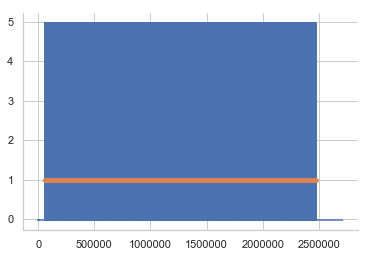

In [31]:
#you might need to run these cells twice to the get the plots for some reason

clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

frame_clock = threshold_detect(clock_voltage, 1)
plt.figure()
plt.plot(clock_voltage)
plt.plot(frame_clock, np.ones(len(frame_clock)), '.')
sns.despine()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

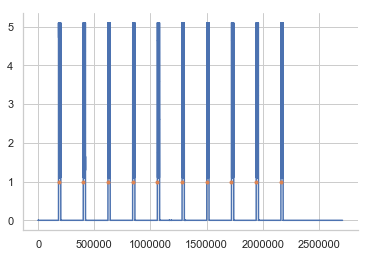

In [32]:
stim_idx = paq['chan_names'].index(stim_name)
stim_volts = paq['data'][stim_idx, :]
stim_times = threshold_detect(stim_volts, 1)

#correct this based on txt file
duration_ms = 1000
frame_rate = 30
duration_frames = np.ceil((duration_ms/1000)*frame_rate)
duration_frames = int(duration_frames)

plt.figure()
plt.plot(stim_volts)
plt.plot(stim_times, np.ones(len(stim_times)), '.')
sns.despine()
plt.show

In [33]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim >= 0)
    stim_start_frames.append(stim_start_frame)
    
stim_start_frames = np.array(stim_start_frames)

#sanity check
assert max(stim_start_frames) < arr.shape[1]

In [34]:
#this is the key parameter for the sta, how many frames before and after the stim do you want to use
pre_frames = 30
post_frames = 30

#list of cell pixel intensity values during each stim on each trial
all_trials = []
# the average of every trial
stas = []

sta_amplitudes = []

t_tests = []
mann_whits = []

#loop through each cell
for i, unit in enumerate(arr):

    trials = []
    amplitudes = []
    df = []
    
    # a flat list of all observations before stim occured
    pre_obs = []
    # a flat list of all observations after stim occured
    post_obs = []
    
    for stim in stim_start_frames:
        
        # get baseline values from pre_stim
        pre_stim_f  = unit[stim-pre_frames : stim]
        baseline = np.mean(pre_stim_f)

        # the whole trial and dfof using baseline
        trial = unit[stim-pre_frames : stim+post_frames]
        trial = [((f-baseline)/ baseline) * 100 for f in trial]
        trials.append(trial)

        pre_stim  = trial[ : pre_frames-1]
        post_stim = trial[pre_frames : ]

        # append to flat lists
        [pre_obs.append(ob) for ob in pre_stim]
        [post_obs.append(ob) for ob in post_stim]

        #calc amplitude of response        
        pre_f = trial[pre_frames - duration_frames : pre_frames]
        pre_f = np.mean(pre_f)
        post_f = trial[pre_frames + 1 : pre_frames + duration_frames]
        post_f = np.mean(post_stim)
        amplitude = post_f - pre_f
        amplitudes.append(amplitude)

        
    trials = np.array(trials)
    all_trials.append(trials)
    
    #average amplitudes across trials
    all_amplitudes = np.array(amplitudes)
    sta_amplitude = np.mean(all_amplitudes,0)
    sta_amplitudes.append(sta_amplitude)

    #average across all trials
    sta = np.mean(trials, 0)        
    stas.append(sta)

    #remove nans from flat lists
    pre_obs = [x for x in pre_obs if ~np.isnan(x)]
    post_obs = [x for x in post_obs if ~np.isnan(x)]
    
    #t_test and man whit test pre and post stim (any other test could also be used here)
    t_test = stats.ttest_ind(pre_obs, post_obs)
    t_tests.append(t_test)
    
    mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
    mann_whits.append(mann_whit)

stas = np.array(stas)
all_trials = np.array(all_trials)   
t_tests = np.array(t_tests)
mann_whits = np.array(mann_whits)

In [35]:
#set this to true if you want to multiple comparisons correct for the number of cells
multi_comp_correction = True
if not multi_comp_correction: 
    divisor = 1
else:
    divisor = num_units

In [36]:
p_vals = [t[1] for t in t_tests]
idx = range(len(p_vals))

if multi_comp_correction:
    print('performing t-test on cells with mutliple comparisons correction')
else:
    print('performing t-test on cells without mutliple comparisons correction')
    
count = 0
sig_units = []
for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / divisor:
        count += 1
        unit_index = stat[i]['original_index']
        print('stimulation has significantly changed fluoresence of s2p unit {}, its P value is {}'.format(unit_index, p))
        sig_units.append(i) #significant units

performing t-test on cells with mutliple comparisons correction
stimulation has significantly changed fluoresence of s2p unit 50, its P value is 1.091563121883839e-77
stimulation has significantly changed fluoresence of s2p unit 16, its P value is 1.1130101902389488e-39
stimulation has significantly changed fluoresence of s2p unit 33, its P value is 3.838659194187789e-30
stimulation has significantly changed fluoresence of s2p unit 13, its P value is 2.4149438290006947e-29
stimulation has significantly changed fluoresence of s2p unit 44, its P value is 3.1432547085183383e-26
stimulation has significantly changed fluoresence of s2p unit 17, its P value is 1.1804377308045322e-25
stimulation has significantly changed fluoresence of s2p unit 19, its P value is 2.323726881187369e-15
stimulation has significantly changed fluoresence of s2p unit 8, its P value is 3.6219351103826196e-15
stimulation has significantly changed fluoresence of s2p unit 200, its P value is 1.4713966370963173e-14
sti

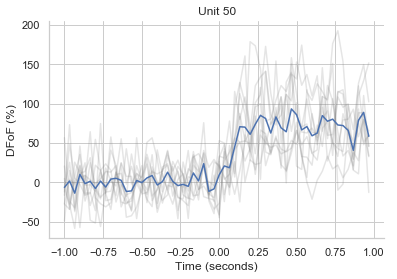

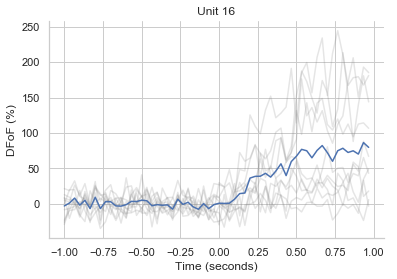

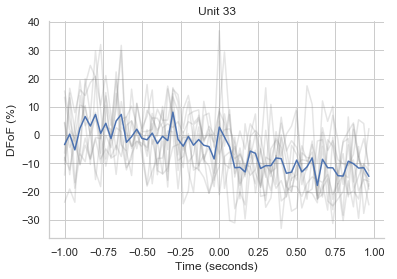

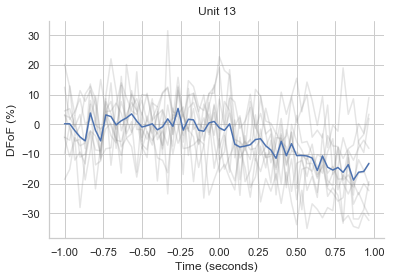

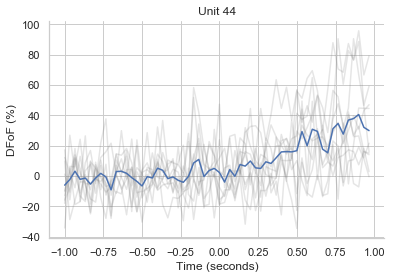

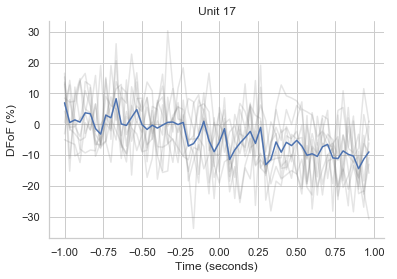

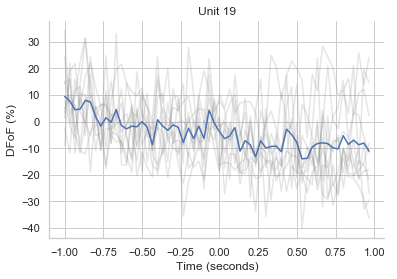

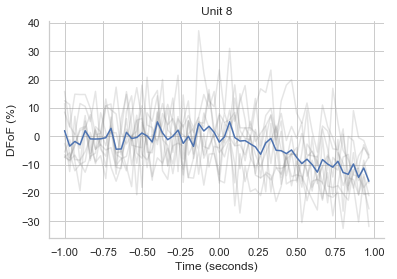

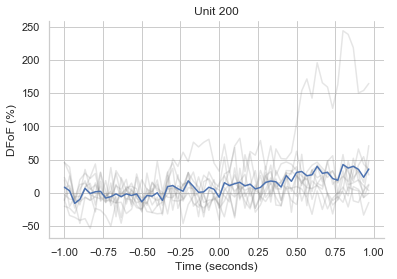

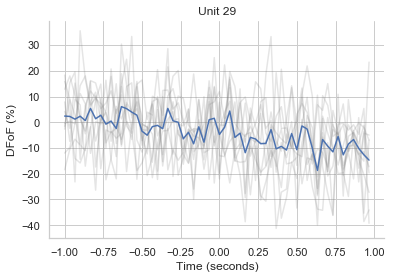

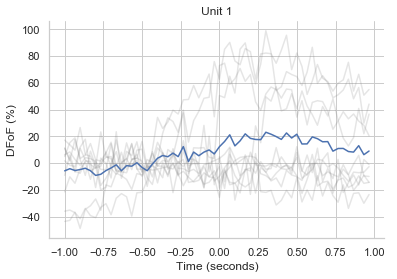

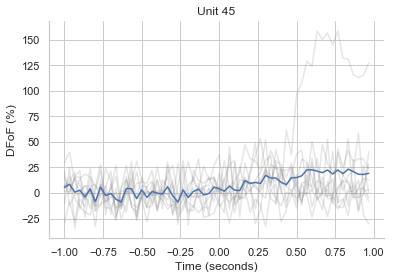

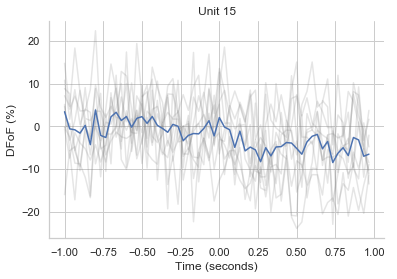

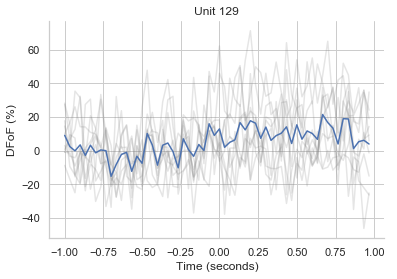

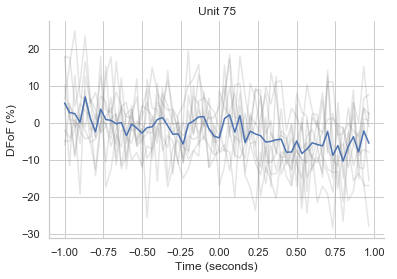

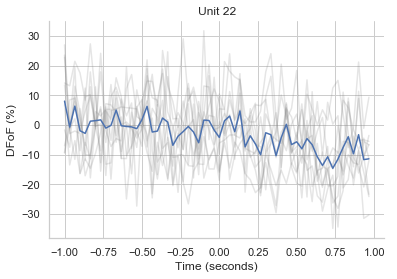

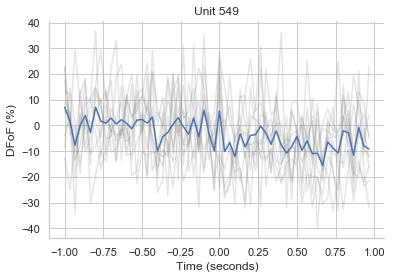

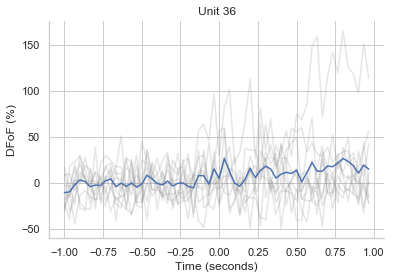

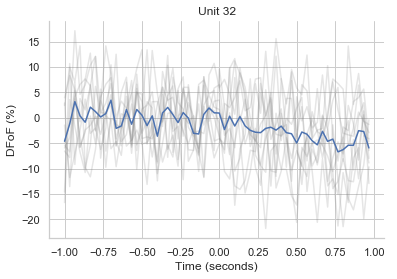

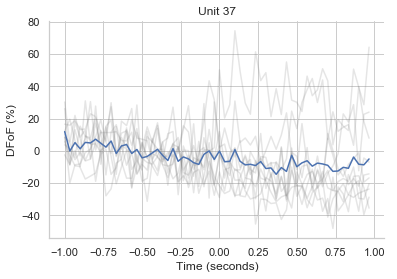

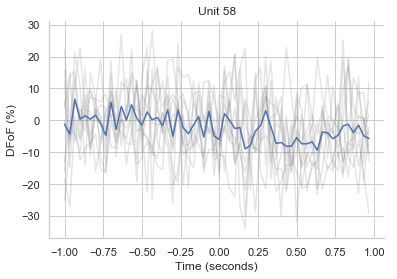

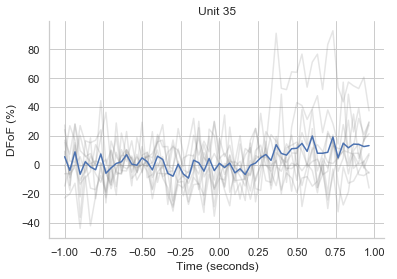

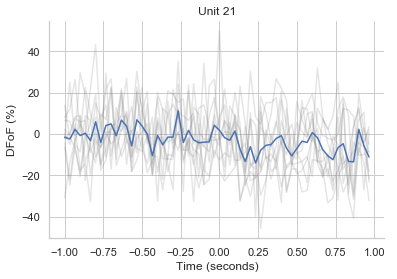

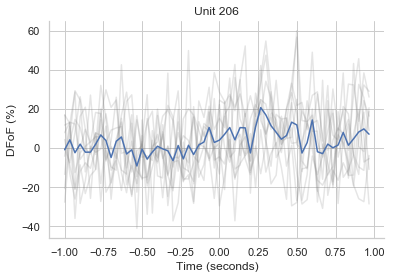

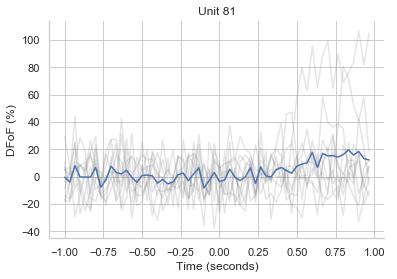

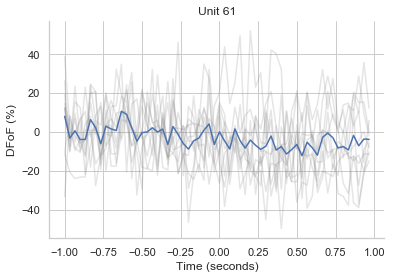

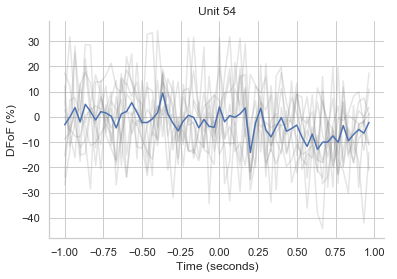

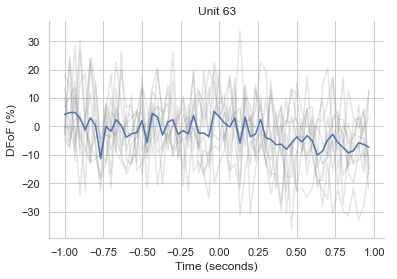

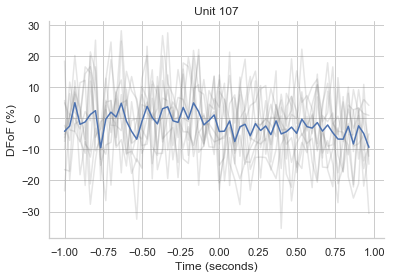

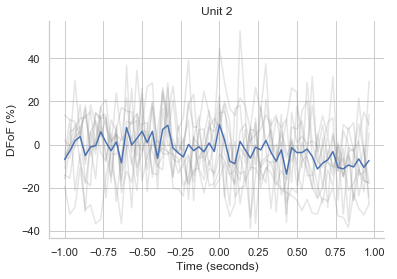

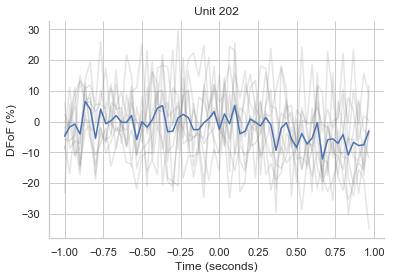

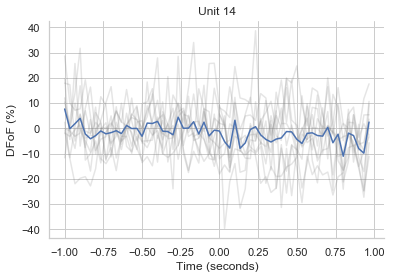

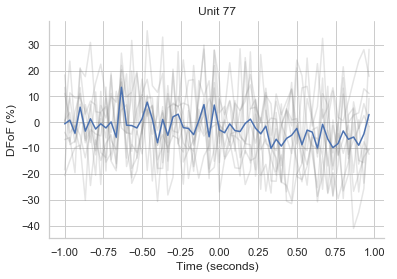

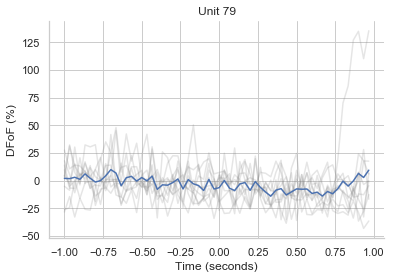

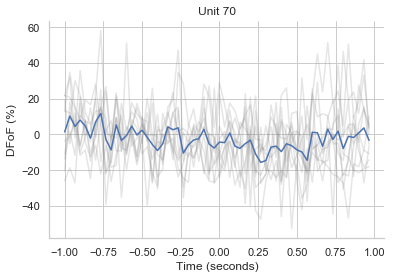

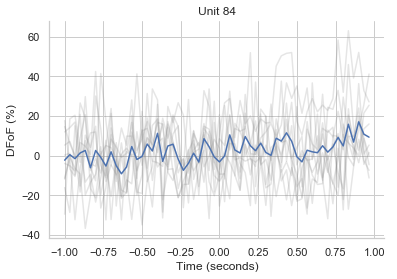

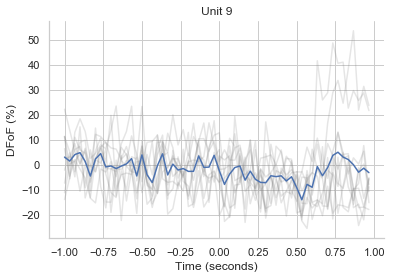

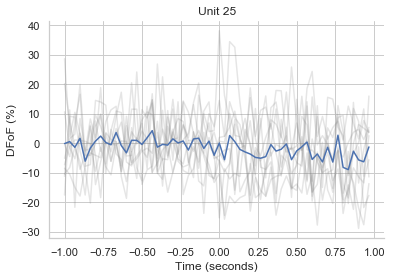

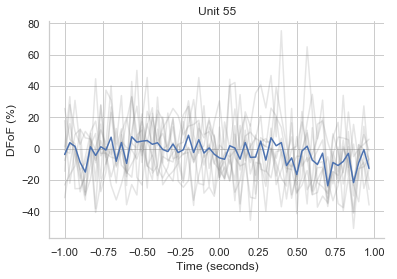

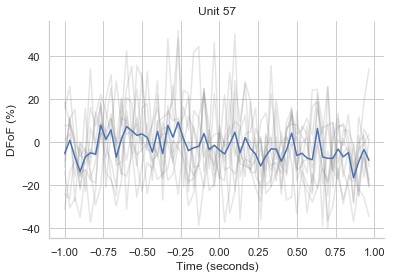

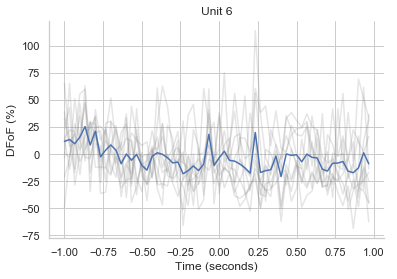

In [37]:
#set the unit number here you want to plot
for i in sig_units:
    unit = i
    unit_index = stat[i]['original_index']
    
    frame_rate = 30
    x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

    plt.figure()

    sta = stas[unit]
    [plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
    plt.plot(x_axis, sta)
    plt.title('Unit ' + str(unit_index))
    plt.xlabel('Time (seconds)')
    plt.ylabel('DFoF (%)')
    #plt.ylim((-100,200))
    sns.despine()
    plt.savefig('s2_responsive_cell.pdf')

In [38]:
sig_amplitudes = [sta_amplitudes[i] for i in sig_units]

np.save(s2p_path + '_sig_sta_amplitudes.npy', sig_amplitudes)

C:\Users\roble\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


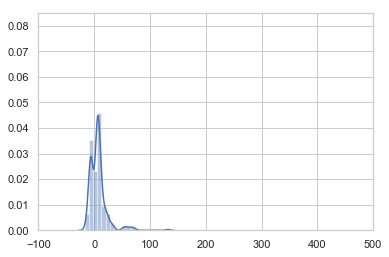

In [42]:
path = r'C:\Users\roble\Documents\Packer lab\Analysis\Whisker stim\Suite2p\Good GCaMP\Whisker stim response amplitudes'

all_amplitudes = []

for dirpath, dirnames, filenames in os.walk(path):
    
    for file in filenames:
        amplitudes = np.load(os.path.join(path, file))
        all_amplitudes.append(amplitudes)
        
all_amplitudes = [amplitude for amplitudes in all_amplitudes for amplitude in amplitudes]

plt.figure
#plt.boxplot(all_amplitudes, notch=True)
sns.distplot(all_amplitudes, bins=20)
plt.axis([-100, 500, 0, 0.085])
plt.savefig(r'C:\Users\roble\Documents\Packer lab\Analysis\Whisker stim\Suite2p\Good GCaMP\Whisker stim response amplitudes.svg')